## Binomial-Gamma Hurdle Models 

### Model description

Dependent variable, y (for example a number of animals observed per minute) is semi-continuous (i.e. a point mass in a single value and a continuous distribution elsewhere). The data generating process for this type of data can be modelled using a gamma distribution. The main problem is however that response variable has a high proportion of zeros (96%), which is more than expected from a gamma distribution, hence it cannot be readily applied.

Lets consider the two common methods for dealing with zero-inflated data:

(1) Modelling a zero-inflation parameter that represents the probability a given 0 comes from the main distribution (say the negative binomial distribution) or is an excess 0;
(2) Modelling the zero and non-zero data with one model and then modelling the non-zero data with another. This is often called a hurdle model.

In (1), the response variable is modelled as a mixture of a Bernoulli distribution (a point mass at zero) and a Poisson distribution (or any other count distribution supported on non-negative integers).
In (2), the basic idea is that a Bernoulli probability governs the binary outcome of whether a variable has a zero or positive realization. If the realization is positive, the hurdle is crossed, and the conditional distribution of the positives is governed by a truncated-at-zero model. Hurdle models model the zeros and non-zeros as two separate processes and can be useful in that they allow you to model the zeros and non-zeros with different predictors or different roles of the same predictors.

Zero-inflation models may be more elegant and informative if the same predictors are thought to contribute to the extra and real zeros. Hurdle models can be useful in that they allow you to model the zeros and non-zeros with different predictors or different roles of the same predictors. Maybe one process leads to the zero/non-zero data and another leads to the non-zero magnitude.

Here we shall focus on (2) and model the zeros separately from the non-zeros in a binomial-Gamma hurdle model.


### Load libraries

In [1]:
library(ggplot2)
# library(lmtest)
# library(tidyverse)
library(lme4)
library(effects)
library(optimx)

Loading required package: Matrix
Loading required package: carData
lattice theme set by effectsTheme()
See ?effectsTheme for details.


In [2]:
set.seed(4322)

In [15]:
# require(devtools)
# install_version("effects", version = "4.0-0")

### Read in data

In [25]:
dat <- read.csv(file = 'data.csv', row.names=1)

Variable y is a response variable, variables x1 and x2 are explanatory variables. Variable x1 represent a number of observers, variable x2 represent an environmental variable (such as sea surface temperature).

In [4]:
head(dat)

y,x1,x2,year
0.0000000,30,10.40875,1971
0.1184611,30,10.40875,1971
0.0000000,90,10.40875,1971
0.0000000,210,10.40875,1971
0.0000000,300,10.40875,1971
0.0000000,150,10.40875,1971


### Scale data

In [33]:
# select variables to scale
cols = c("x1", "x2")
# scale variables and add to a df
dat[, paste0(cols, "_", "sc")] <- scale(dat[ ,cols])
summary(dat)

       y                  x1            x2              year     
 Min.   :0.000000   Min.   :  5   Min.   : 9.207   Min.   :1971  
 1st Qu.:0.000000   1st Qu.: 30   1st Qu.:13.169   1st Qu.:1984  
 Median :0.000000   Median : 60   Median :15.261   Median :1998  
 Mean   :0.002485   Mean   :128   Mean   :14.621   Mean   :1996  
 3rd Qu.:0.000000   3rd Qu.:180   3rd Qu.:16.288   3rd Qu.:2009  
 Max.   :0.133199   Max.   :960   Max.   :18.168   Max.   :2017  
                    NA's   :363   NA's   :61                     
     x1_sc             x2_sc        
 Min.   :-0.8945   Min.   :-2.5651  
 1st Qu.:-0.7126   1st Qu.:-0.6882  
 Median :-0.4944   Median : 0.3032  
 Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.3786   3rd Qu.: 0.7894  
 Max.   : 6.0531   Max.   : 1.6802  
 NA's   :363       NA's   :61       

### Binomial model

When relating the sightings to temperature what we are interested in detecting are annual trends over and above seasonal fluctuations that we would expect. So we would expect that within each year as temperature increases during spring and summer and zooplankton blooms occur, sunfish sightings will increase. What we want to know is -- in a year when zooplankton abundance and temperatures are high are sunfish sightings also high. 


In [6]:
summary(glm(ifelse(dat$y>0,1,0) ~
            x1_sc +
            x2_sc +
            year,
            data = dat,
        family = binomial(link = logit)))


Call:
glm(formula = ifelse(dat$y > 0, 1, 0) ~ x1_sc + x2_sc + year, 
    family = binomial(link = logit), data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.3114  -0.2885  -0.2789  -0.2601   2.8235  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -0.152262  12.235934  -0.012   0.9901  
x1_sc       -0.174758   0.102027  -1.713   0.0867 .
x2_sc       -0.052618   0.080658  -0.652   0.5142  
year        -0.001567   0.006135  -0.255   0.7984  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1455.7  on 4609  degrees of freedom
Residual deviance: 1450.7  on 4606  degrees of freedom
  (365 observations deleted due to missingness)
AIC: 1458.7

Number of Fisher Scoring iterations: 6


We see that observer related variables (x1) is significant. We try to isolate its effect for each year.
We apply a mixed-effect modeling framework and fit a varying intercept model with lmer. This approach is useful when we are interested explicitly in variation among and by groups. Group level variables are specified using a special syntax: (1|year) to fit a linear model with a varying-intercept group effect using the variable year.



We include 'year' as random effect with noise variables.

In [7]:
m.bin.full.re <- glmer(ifelse(dat$y>0,1,0) ~
             x1_sc +
             (1|year) ,
           data = dat,
#            control = glmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')),
           family = binomial(link = logit))

In [8]:
summary(m.bin.full.re)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: ifelse(dat$y > 0, 1, 0) ~ x1_sc + (1 | year)
   Data: dat

     AIC      BIC   logLik deviance df.resid 
  1457.4   1476.7   -725.7   1451.4     4609 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2114 -0.2066 -0.2027 -0.1871  7.2335 

Random effects:
 Groups Name        Variance Std.Dev.
 year   (Intercept) 0.002407 0.04907 
Number of obs: 4612, groups:  year, 44

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.27872    0.08461 -38.751   <2e-16 ***
x1_sc       -0.18641    0.09471  -1.968    0.049 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
      (Intr)
x1_sc 0.147 

Random effects are conditional modes - the difference between the average predicted response for a given set of fixed-effect values (observer related variables) and the response predicted for particular year.

In [12]:
ranef.bin.dat<-as.data.frame(ranef(m.bin.full.re))[c(3,4)]
# rename
colnames(ranef.bin.dat)[2] <- "reyear"

In [13]:
head(ranef.bin.dat)

grp,reyear
1971,0.0137390698
1972,0.0035901339
1973,-0.0042083611
1974,-0.0048717533
1975,0.0022349064
1976,0.0009954729


In [14]:
# merge with dat by column year
dat.bin.re<-merge(dat,ranef.bin.dat, by.x = "year", by.y = "grp")

In [15]:
head(dat.bin.re)

year,y,x1,x2,x1_sc,x2_sc,reyear
1971,0.0000000,30,10.40875,-0.7126393,-1.995932,0.01373907
1971,0.1184611,30,10.40875,-0.7126393,-1.995932,0.01373907
1971,0.0000000,90,10.40875,-0.2761402,-1.995932,0.01373907
1971,0.0000000,210,10.40875,0.5968579,-1.995932,0.01373907
1971,0.0000000,300,10.40875,1.2516065,-1.995932,0.01373907
1971,0.0000000,150,10.40875,0.1603588,-1.995932,0.01373907


Fit variable x2 against ranef.year

In [19]:
m.bin.full <- glm(reyear ~
                  x2_sc,
           data = dat.bin.re,
           family = gaussian)

In [20]:
summary(m.bin.full)


Call:
glm(formula = reyear ~ x2_sc, family = gaussian, data = dat.bin.re)

Deviance Residuals: 
      Min         1Q     Median         3Q        Max  
-0.008938  -0.003452  -0.001559   0.003270   0.013473  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.589e-04  7.320e-05   4.903 9.73e-07 ***
x2_sc       -1.235e-04  7.321e-05  -1.687   0.0916 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 2.633023e-05)

    Null deviance: 0.12941  on 4913  degrees of freedom
Residual deviance: 0.12933  on 4912  degrees of freedom
  (61 observations deleted due to missingness)
AIC: -37868

Number of Fisher Scoring iterations: 2



The model predicted RE for each year, assuming all other model variables remain constant

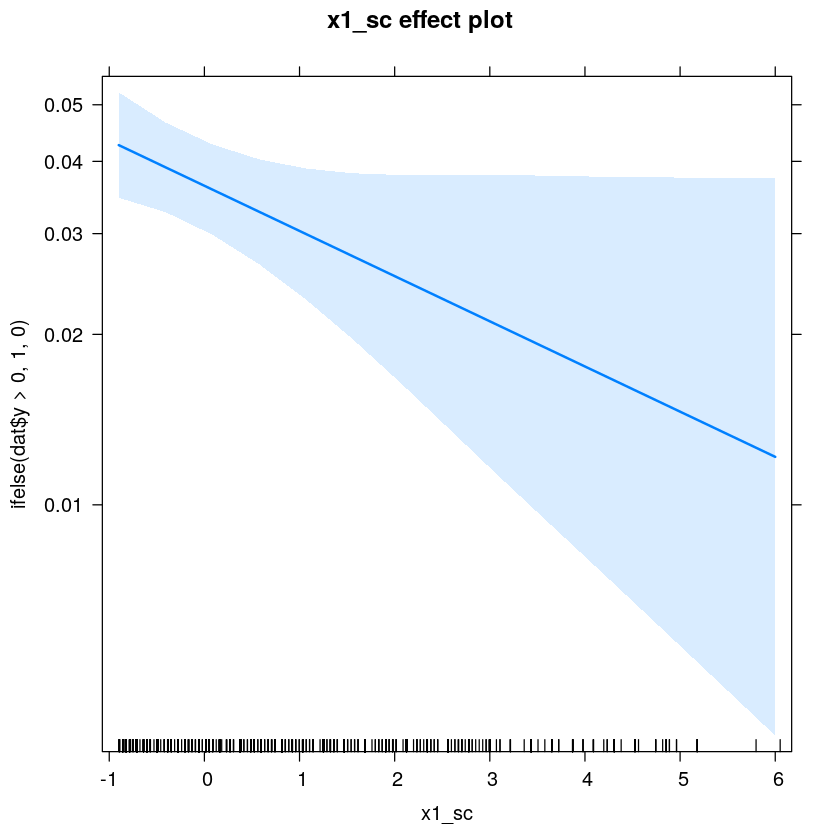

In [22]:
plot(allEffects(m.bin.full.re))

### Gamma model

In [34]:
# drop rows with nas
no.na.dat <- na.omit(dat)

We fit Gamma model to the positive part of the model with log link using a similar set of predictors.

In [35]:
summary(glm(y ~
            year +
            x1_sc +
            x2_sc,
            data = subset(no.na.dat, y>0),
            family = Gamma(link = log)))


Call:
glm(formula = y ~ year + x1_sc + x2_sc, family = Gamma(link = log), 
    data = subset(no.na.dat, y > 0))

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.29973  -0.58475   0.05655   0.41737   0.89432  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -10.032208   6.618597  -1.516    0.131
year          0.003676   0.003318   1.108    0.269
x1_sc        -0.044201   0.060329  -0.733    0.465
x2_sc         0.014744   0.047531   0.310    0.757

(Dispersion parameter for Gamma family taken to be 0.3448597)

    Null deviance: 104.02  on 169  degrees of freedom
Residual deviance: 103.22  on 166  degrees of freedom
AIC: -593.9

Number of Fisher Scoring iterations: 5


We consider only positive observations (99) and separate observer related effect for each year.

In [38]:
m.gamma.full.re <- glmer(y ~
             x1_sc +
             (1|year),
            data = subset(no.na.dat, y>0),
            #control = glmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')),
           family = Gamma(link = log))

singular fit


In [39]:
summary(m.gamma.full.re)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( log )
Formula: y ~ x1_sc + (1 | year)
   Data: subset(no.na.dat, y > 0)

     AIC      BIC   logLik deviance df.resid 
  -593.0   -580.4    300.5   -601.0      166 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6776 -0.8645  0.1301  0.8736  1.7613 

Random effects:
 Groups   Name        Variance Std.Dev.
 year     (Intercept) 0.0000   0.0000  
 Residual             0.3362   0.5798  
Number of obs: 170, groups:  year, 39

Fixed effects:
            Estimate Std. Error t value Pr(>|z|)    
(Intercept) -2.69798    0.05806 -46.467   <2e-16 ***
x1_sc       -0.04962    0.06810  -0.729    0.466    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
      (Intr)
x1_sc 0.175 
convergence code: 0
singular fit


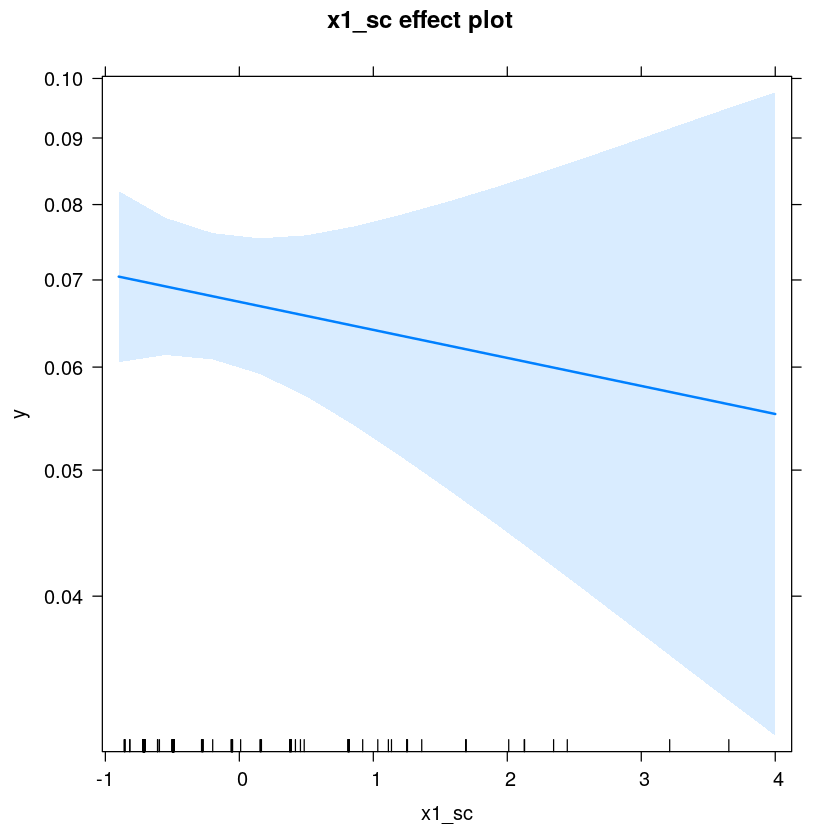

In [45]:
plot(allEffects(m.gamma.full.re))


In [40]:
# extract random effect
ranef.gamma.dat<-as.data.frame(ranef(m.gamma.full.re))[c(3,4)]

In [42]:
colnames(ranef.gamma.dat)[2] <- "reyear"

In [43]:
dat.gamma.re <- merge(subset(no.na.dat, y>0),ranef.gamma.dat, by.x = "year", by.y = "grp")

In [46]:
# fit the rest of the variables against ranef.year
m.gamma.full <- glm(reyear ~
            x2_sc,
           data = dat.gamma.re,
           family = gaussian)

In [47]:
summary(m.gamma.full)


Call:
glm(formula = reyear ~ x2_sc, family = gaussian, data = dat.gamma.re)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
     0       0       0       0       0  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)        0          0      NA       NA
x2_sc              0          0      NA       NA

(Dispersion parameter for gaussian family taken to be 0)

    Null deviance: 0  on 169  degrees of freedom
Residual deviance: 0  on 168  degrees of freedom
AIC: -Inf

Number of Fisher Scoring iterations: 1


### References

* https://www.ssc.wisc.edu/sscc/pubs/MM/MM_DiagInfer.html
* http://rstudio-pubs-static.s3.amazonaws.com/5691_192685385fc445c9b3fb1619960a20e2.html
* http://pj.freefaculty.org/guides/stat/Regression-GLM/Gamma/GammaGLM-01.pdf
* https://stats.stackexchange.com/questions/81457/what-is-the-difference-between-zero-inflated-and-hurdle-distributions-models
* http://seananderson.ca/2014/05/18/gamma-hurdle.html
* https://ms.mcmaster.ca/~bolker/R/misc/modelDiag.html
* https://stats.idre.ucla.edu/r/dae/logit-regression/
* https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/
* http://environmentalcomputing.net/interpreting-coefficients-in-glms/
* https://www.sciencedirect.com/science/article/pii/S0167947308000169
* https://www.cambridge.org/core/services/aop-cambridge-core/content/view/S0021859611000608
* https://link.springer.com/article/10.1007/s10742-017-0169-9
* https://stats.stackexchange.com/questions/96972/how-to-interpret-parameters-in-glm-with-family-gamma/126225
* https://stats.stackexchange.com/questions/161216/backtransform-coefficients-of-a-gamma-log-glmm